# What Is the Optimal Strategy for a Media Store?

## Abstract

- The aim of the project is to provide with an overview of the digital media products global market and to propose an optimal strategy with respect to employees, customers' preferences and media products purchasing decisions, so that to maximize revenue and minimize costs.
- To accomplish the above-mentioned goal we introduce [Chinook database](https://archive.codeplex.com/?p=chinookdatabase), which contains tables covering information about employees, customers, purchases and media content in a set of inter-related tables. Media-related data were created using real data from an Apple iTunes library, customer and employee information was created using fictitious names and addresses, while sales information was auto generated using random data for a four year period.
- At the end of our analysis we recommend digital media stores to hire **experienced salesmen**, purchase rather **unprotected media**, while paying special attention to artists/bands from the **Rock, Alternative & Punk and Metal genres** and make such decisions on the **track-by-track basis** taking into account previously accumulated empirics, rather than composers' pure popularity. **Albums are also an important source of sales**, so than the same approach should be applied here as well. The bands almost surely guaranteeing good sales record are **Red Hot Chili Peppers, Queen and Guns N' Roses**, since according to our data all of their distinct tracks were sold completely.

## Initial Data Exploration

Let's check the scheme of tables and the connections between them, which we can refer to later on while making queries.

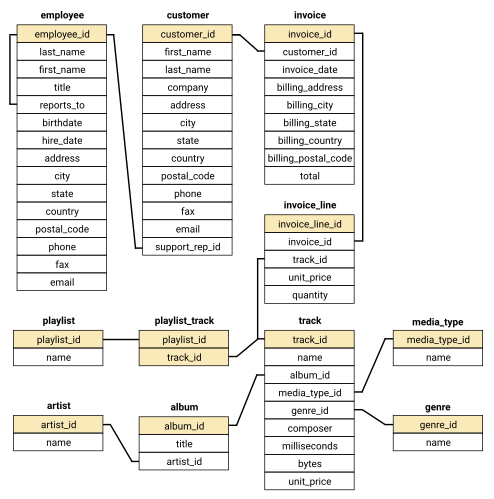

In [1]:
from IPython.display import SVG
SVG('/Users/mac/downloads/chinook-schema.svg')

Overall we have 11 tables connected through various ids, which allows us to merge them and to make the necessary comparisons.

Let's upload the Chinook database and check the list of tables.

In [2]:
%%capture
%load_ext sql
%sql sqlite:////Users/mac/downloads/chinook.db

In [3]:
%%sql

SELECT
    name, type
FROM sqlite_master
WHERE type IN ("table","view")

 * sqlite:////Users/mac/downloads/chinook.db
Done.


name,type
album,table
artist,table
customer,table
employee,table
genre,table
invoice,table
invoice_line,table
media_type,table
playlist,table
playlist_track,table


## The US Is the Largest Market with a Significant Difference from the Rest

Let's explore first the distribution of sales across countries, so that to figure out which region we should pay  attention the most.

In [4]:
%%sql

WITH tracks_sold_globally AS
    (
    SELECT COUNT(il.quantity) number_of_tracks_sold, c.country country, COUNT(DISTINCT c.customer_id) customer_id, 
    SUM(il.unit_price) total
    FROM invoice_line il
    INNER JOIN invoice i ON i.invoice_id = il.invoice_id
    INNER JOIN customer c ON c.customer_id = i.customer_id
    GROUP BY 2 ORDER BY 1 DESC
    ) 
    
SELECT 
    country 'Country', tsg.number_of_tracks_sold 'Tracks Sold', 
    ROUND(tsg.number_of_tracks_sold/(SELECT CAST(SUM(tsg.number_of_tracks_sold) AS FLOAT) FROM tracks_sold_globally tsg)*100,2) 'Percentage in Total Tracks Sold',
    ROUND(tsg.total,2) 'Revenue',
    ROUND(tsg.total/(SELECT CAST(SUM(tsg.total) AS FLOAT) FROM tracks_sold_globally tsg)*100,2) 'Percentage in Total Revenue',
    tsg.customer_id 'Number of Customers'
FROM tracks_sold_globally tsg

 * sqlite:////Users/mac/downloads/chinook.db
Done.


Country,Tracks Sold,Percentage in Total Tracks Sold,Revenue,Percentage in Total Revenue,Number of Customers
USA,1051,22.09,1040.49,22.09,13
Canada,541,11.37,535.59,11.37,8
Brazil,432,9.08,427.68,9.08,5
France,393,8.26,389.07,8.26,5
Germany,338,7.11,334.62,7.11,4
Czech Republic,276,5.8,273.24,5.8,2
United Kingdom,248,5.21,245.52,5.21,3
Portugal,187,3.93,185.13,3.93,2
India,185,3.89,183.15,3.89,2
Ireland,116,2.44,114.84,2.44,1


The output table shows us that the US market is leading both in terms of tracks sold (22%) and revenue (22%), while the number of customers there is also the largest. It is followed by Canada and Brazil both in terms of tracks sold and revenue. It is noteworthy, that there are much more distinct customers in Americas as compared to other countries.

Let's explore further average sales and orders among various countries - it may allow us to understand where customers order the most.

In [5]:
%%sql

DROP VIEW other_countries;

CREATE VIEW other_countries AS
    SELECT
         c.country country, ROUND(SUM(i.total),2) total_sales, ROUND(AVG(i.total),2) average_sales, 
         COUNT(DISTINCT c.customer_id) number_of_customers
    FROM invoice i
    INNER JOIN customer c ON c.customer_id = i.customer_id
    GROUP by 1
    ORDER by 2 DESC;

SELECT
    country 'Country', total_sales 'Total Revenue', average_sales 'Average Revenue', average_order 'Average Order', number_of_customers 'Number of Customers'
FROM
(
    SELECT 
    CASE
        WHEN number_of_customers = 1 THEN 'Other countries'
        ELSE other_countries.country
    END AS country, 
    ROUND(SUM(total_sales),2) total_sales, ROUND(AVG(average_sales),2) average_sales, 
    SUM(number_of_customers) number_of_customers, ROUND(SUM(total_sales)/SUM(number_of_customers),2) average_order, 
    CASE
        WHEN number_of_customers = 1 THEN 1
        ELSE 0
    END AS sort
    FROM other_countries
    GROUP by 1
    ORDER by sort ASC, 2 DESC
);

 * sqlite:////Users/mac/downloads/chinook.db
Done.
Done.
Done.


Country,Total Revenue,Average Revenue,Average Order,Number of Customers
USA,1040.49,7.94,80.04,13
Canada,535.59,7.05,66.95,8
Brazil,427.68,7.01,85.54,5
France,389.07,7.78,77.81,5
Germany,334.62,8.16,83.66,4
Czech Republic,273.24,9.11,136.62,2
United Kingdom,245.52,8.77,81.84,3
Portugal,185.13,6.38,92.57,2
India,183.15,8.72,91.58,2
Other countries,1094.94,7.44,73.0,15


We can see that even though the US market is the leading one in terms of total sales, but bigger orders have taken place in Czech Republic, Portugal, India and some other countries.

Finally, let's see what salesmen of our digital store generate more revenue.

In [6]:
%%sql

SELECT e.first_name || ' ' || e.last_name 'Employee Name', e.birthdate 'Date of Birth', e.hire_date 'Date of Hire', 
ROUND(SUM(i.total),2) 'Total Revenue'
FROM employee e
INNER JOIN customer c ON c.support_rep_id = e.employee_id
INNER JOIN invoice i ON i.customer_id = c.customer_id
GROUP BY 1 ORDER BY 4 DESC

 * sqlite:////Users/mac/downloads/chinook.db
Done.


Employee Name,Date of Birth,Date of Hire,Total Revenue
Jane Peacock,1973-08-29 00:00:00,2017-04-01 00:00:00,1731.51
Margaret Park,1947-09-19 00:00:00,2017-05-03 00:00:00,1584.0
Steve Johnson,1965-03-03 00:00:00,2017-10-17 00:00:00,1393.92


Sales experience seems to be a determining factors in the amount of sales of each employee, while age is not that relevant.

## Rock Genre Is the Most Promising

Let's check sales in the US in closer detail, so that to figure out what music genres are the most popular there, what are the most profitable in terms of revenue and then compare these figures to the global ones.

In [7]:
%%sql

WITH tracks_sold_in_US AS
    (
    SELECT COUNT(t.genre_id) number_of_tracks_sold, g.name, SUM(il.unit_price) total
    FROM track t
    INNER JOIN genre g ON g.genre_id = t.genre_id
    INNER JOIN invoice_line il ON t.track_id = il.track_id
    INNER JOIN invoice i ON i.invoice_id = il.invoice_id
    WHERE billing_country = 'USA'
    GROUP BY 2 ORDER BY 1 DESC
    ) 
    
SELECT 
    tsu.name 'Genre', tsu.number_of_tracks_sold 'Tracks Sold', 
    ROUND(tsu.number_of_tracks_sold/(SELECT CAST(SUM(tsu.number_of_tracks_sold) AS FLOAT) FROM tracks_sold_in_US tsu)*100,2) 'Percentage in Total Tracks Sold',
    ROUND(tsu.total,2) 'Revenue', 
    ROUND(tsu.total/(SELECT CAST(SUM(tsu.total) AS FLOAT) FROM tracks_sold_in_US tsu)*100,2) 'Percentage in Total Revenue'
FROM tracks_sold_in_US tsu

 * sqlite:////Users/mac/downloads/chinook.db
Done.


Genre,Tracks Sold,Percentage in Total Tracks Sold,Revenue,Percentage in Total Revenue
Rock,561,53.38,555.39,53.38
Alternative & Punk,130,12.37,128.7,12.37
Metal,124,11.8,122.76,11.8
R&B/Soul,53,5.04,52.47,5.04
Blues,36,3.43,35.64,3.43
Alternative,35,3.33,34.65,3.33
Pop,22,2.09,21.78,2.09
Latin,22,2.09,21.78,2.09
Hip Hop/Rap,20,1.9,19.8,1.9
Jazz,14,1.33,13.86,1.33


The results above indicate that Rock genre is the most popular (53% of total tracks sold) and the most profitable (54% of total revenue), while the difference with all the other genres is enormous, meaning that exaclty this one is the most promising for media stores. 

Let's compare these figure to sales in all markets.

In [8]:
%%sql

WITH tracks_sold AS
    (
    SELECT COUNT(t.genre_id) number_of_tracks_sold, g.name, SUM(il.unit_price) total
    FROM track t
    INNER JOIN genre g ON g.genre_id = t.genre_id
    INNER JOIN invoice_line il ON il.track_id = t.track_id
    INNER JOIN invoice i ON i.invoice_id = il.invoice_id
    GROUP BY 2 ORDER BY 1 DESC
    ) 
    
SELECT 
    ts.name 'Genre', ts.number_of_tracks_sold 'Tracks Sold', 
    ROUND(ts.number_of_tracks_sold/(SELECT CAST(SUM(ts.number_of_tracks_sold) AS FLOAT) FROM tracks_sold ts)*100,2) 'Percentage in Total Tracks Sold', 
    ROUND(ts.total/(SELECT CAST(SUM(ts.total) AS FLOAT) FROM tracks_sold ts)*100,2) 'Percentage in Total Revenue'
FROM tracks_sold ts

 * sqlite:////Users/mac/downloads/chinook.db
Done.


Genre,Tracks Sold,Percentage in Total Tracks Sold,Percentage in Total Revenue
Rock,2635,55.39,55.39
Metal,619,13.01,13.01
Alternative & Punk,492,10.34,10.34
Latin,167,3.51,3.51
R&B/Soul,159,3.34,3.34
Blues,124,2.61,2.61
Jazz,121,2.54,2.54
Alternative,117,2.46,2.46
Easy Listening,74,1.56,1.56
Pop,63,1.32,1.32


In the case of global sales Rock is again the most popular in terms of tracks sold and in terms of revenue with overwhelming difference from the rest, indicating that the difference with the US market sales is negligible. Therefore, there is no need to differentiate across the US and the global market when making recommendations in this respect.

## Queen, Jimi Hendrix and Red Hot Chili Peppers Are the Most Popular Artists/Bands

Let's explore further the top 20 bands which are sold the most and how it corresponds to the genres above, so that to make a potential purchasing recommendation for digital media stores.

In [9]:
%%sql

WITH artists_sold_globally AS
    (
    SELECT SUM(il.quantity) number_of_tracks_sold, a.name artist_name, g.name genre_name, SUM(il.unit_price) total
    FROM artist a
    INNER JOIN album al ON al.artist_id = a.artist_id
    INNER JOIN track t ON t.album_id = al.album_id
    INNER JOIN invoice_line il ON il.track_id = t.track_id
    INNER JOIN invoice i ON i.invoice_id = il.invoice_id
    INNER JOIN genre g ON g.genre_id = t.genre_id
    GROUP BY 2 ORDER BY 1 DESC
    ) 
    
SELECT 
    asg.artist_name 'Artist/Band name', asg.genre_name 'Genre', asg.number_of_tracks_sold 'Tracks Sold',
    ROUND(asg.number_of_tracks_sold/(SELECT CAST(SUM(asg.number_of_tracks_sold) AS FLOAT) FROM artists_sold_globally asg)*100,2) 'Percentage in Total Tracks Sold',
    ROUND(asg.total,2) 'Revenue',
    ROUND(asg.total/(SELECT CAST(SUM(asg.total) AS FLOAT) FROM artists_sold_globally asg)*100,2) 'Percentage in Total Revenue'
FROM artists_sold_globally asg
LIMIT 20

 * sqlite:////Users/mac/downloads/chinook.db
Done.


Artist/Band name,Genre,Tracks Sold,Percentage in Total Tracks Sold,Revenue,Percentage in Total Revenue
Queen,Rock,192,4.04,190.08,4.04
Jimi Hendrix,Rock,187,3.93,185.13,3.93
Red Hot Chili Peppers,Rock,130,2.73,128.7,2.73
Nirvana,Rock,130,2.73,128.7,2.73
Pearl Jam,Rock,129,2.71,127.71,2.71
Guns N' Roses,Rock,124,2.61,122.76,2.61
AC/DC,Rock,124,2.61,122.76,2.61
Foo Fighters,Rock,121,2.54,119.79,2.54
The Rolling Stones,Rock,117,2.46,115.83,2.46
Metallica,Metal,106,2.23,104.94,2.23


The top 10 artists/bands sold globally are all from Rock genre with evident difference from the rest in terms of tracks sold, while on average the price per track seems to be similar for all artists/bands. Overall, we would propose digital media stores to pay attention exactly to these artists/bands when making their purchasing decisions.

## Not All Customers Prefer Purchasing Distinct Tracks - Album Purchases Are Also an Important Source of Revenue

Now that we know what genres and artists are the most popular and thus revenue-generating ones, let's check if customers of our digital store do usually order single tracks or buy whole albums. The answer to this question may help optimizing purchasing strategy to accomodate better to customer's needs, while eliminating unnecessary purchases.

In [10]:
%%sql

WITH invoice_first_track AS
(
SELECT il.invoice_id, MIN(il.track_id) min_track_id, SUM(unit_price*quantity) summation
FROM invoice_line il
GROUP BY 1
)

SELECT 
    CASE
        WHEN(
            SELECT il2.track_id FROM invoice_line il2
            WHERE il2.invoice_id = ift.invoice_id
            EXCEPT
            SELECT t.track_id FROM track t
            WHERE t.album_id = (
                                SELECT t2.album_id FROM track t2
                                WHERE t2.track_id = ift.min_track_id
                                     )
            ) IS NULL
            AND
            (
            SELECT t.track_id FROM track t
            WHERE t.album_id = (
                                SELECT t2.album_id FROM track t2
                                WHERE t2.track_id = ift.min_track_id
                                     )
            EXCEPT
            SELECT il2.track_id FROM invoice_line il2
            WHERE il2.invoice_id = ift.invoice_id
            ) IS NULL
            THEN "Yes"
            ELSE "No"
        END AS 'Album Purchase',
    COUNT(invoice_id) 'Number of Purchases', ROUND(CAST(COUNT(invoice_id) AS FLOAT)/(SELECT
                COUNT(invoice_id) FROM invoice_first_track)*100,2) 'Percentage in Total Purchases', 
                ROUND(SUM(summation),2) 'Purchases Sum'
FROM invoice_first_track ift
GROUP BY 1

 * sqlite:////Users/mac/downloads/chinook.db
Done.


Album Purchase,Number of Purchases,Percentage in Total Purchases,Purchases Sum
No,500,81.43,3248.19
Yes,114,18.57,1461.24


The album purchases are 18.57% of the total indicating that not all customers prefer choosing distinct tracks. Henceforth, purchasing only the most popular tracks and no albums might deprive digital media stores of additional revenue. The total sum of purchases is even more indicative of the importance of album purchases in our media store's revenue - around 30% comes from this source. Henceforh, both albums and distinct tracks should be purchased in general.

We already know which artists/bands are the most popular among customers of our digital store - let's now explore what albums are sold the most and if there is intersection between the two.

In [22]:
%%sql

WITH invoice_first_track AS
(
SELECT il.invoice_id, MIN(il.track_id) min_track_id, SUM(il.unit_price*il.quantity) summation, ar.name name, 
    a.title title, g.name genre, SUM(il.quantity) quantity
FROM invoice_line il
INNER JOIN track t ON t.track_id = il.track_id
INNER JOIN album a ON a.album_id = t.album_id
INNER JOIN artist ar ON ar.artist_id = a.artist_id
INNER JOIN genre g ON g.genre_id = t.genre_id
GROUP BY 1
)

SELECT 
    CASE
        WHEN(
            SELECT il2.track_id FROM invoice_line il2
            WHERE il2.invoice_id = ift.invoice_id
            EXCEPT
            SELECT t.track_id FROM track t
            WHERE t.album_id = (
                                SELECT t2.album_id FROM track t2
                                WHERE t2.track_id = ift.min_track_id
                                     )
            ) IS NULL
            AND
            (
            SELECT t.track_id FROM track t
            WHERE t.album_id = (
                                SELECT t2.album_id FROM track t2
                                WHERE t2.track_id = ift.min_track_id
                                     )
            EXCEPT
            SELECT il2.track_id FROM invoice_line il2
            WHERE il2.invoice_id = ift.invoice_id
            ) IS NULL
            THEN "Yes"
            ELSE "No"
        END AS Album,
    ift.name 'Artist/Band Name', ift.title 'Album Name', ift.genre 'Genre', ROUND(SUM(summation),2) 'Sales', 
    COUNT(ift.quantity) 'Albums Purchased'
FROM invoice_first_track ift
WHERE Album = 'Yes'
GROUP BY 3 ORDER BY 5 DESC
LIMIT 20

 * sqlite:////Users/mac/downloads/chinook.db
Done.


Album,Artist/Band Name,Album Name,Genre,Sales,Albums Purchased
Yes,Jimi Hendrix,Are You Experienced?,Rock,100.98,6
Yes,JET,Get Born,Alternative & Punk,51.48,4
Yes,Queen,News Of The World,Rock,43.56,4
Yes,Miles Davis,Miles Ahead,Jazz,41.58,3
Yes,The Cult,"Pure Cult: The Best Of The Cult (For Rockers, Ravers, Lovers & Sinners) [uk]",Rock,35.64,2
Yes,Marisa Monte,Barulhinho Bom,Latin,35.64,2
Yes,Queen,Greatest Hits I,Rock,33.66,2
Yes,R.E.M.,Green,Alternative & Punk,32.67,3
Yes,Red Hot Chili Peppers,Californication,Rock,29.7,2
Yes,Aerosmith,Big Ones,Rock,29.7,2


The output of the query tells us that albums of Rock artists/bands again enjoy most popularity, though there are also albums from other genres among the top 10 by sales. Moreover, the list of top artists/bands is somewhat different from the one we have seen before covering most popular tracks - only Queen and Jimi Hendrix remain almost unchanged within top 5. Overall, we would recommend digital media stores purchasing albums presented in this list so that to accommodate to the most common preferences of customers around the globe.

## Classical Music Is Omnipresent Among Various Playlists, But Rock and Pop Are the Most Popular

To understand customers' preferences in greater detail, we may also refer to playlists and explore what artists and genres are most popular there.

In [12]:
%%sql

WITH playlists AS
    (
    SELECT COUNT(DISTINCT p.playlist_id) playlist_count, p.name, ar.name artist_name, g.name genre
    FROM track t
    LEFT JOIN genre g ON g.genre_id = t.genre_id
    INNER JOIN playlist_track pt ON pt.track_id = t.track_id
    INNER JOIN playlist p ON p.playlist_id = pt.playlist_id
    INNER JOIN album a ON a.album_id = t.album_id
    INNER JOIN artist ar ON ar.artist_id = a.artist_id
    GROUP BY 3 ORDER BY 1 DESC
    ) 
    
SELECT pl.name 'Playlist Name', pl.playlist_count 'Number of Occurencies in Distinct Playlists', 
        pl.artist_name 'Artist/Band', pl.genre 'Genre'
    
FROM playlists pl
LIMIT 20

 * sqlite:////Users/mac/downloads/chinook.db
Done.


Playlist Name,Number of Occurencies in Distinct Playlists,Artist/Band,Genre
Music,7,Eugene Ormandy,Classical
Music,6,The King's Singers,Classical
Music,6,English Concert & Trevor Pinnock,Classical
Music,6,Berliner Philharmoniker & Herbert Von Karajan,Classical
Music,6,Academy of St. Martin in the Fields & Sir Neville Marriner,Classical
Music,5,Yo-Yo Ma,Classical
Music,5,Wilhelm Kempff,Classical
Music,5,Ton Koopman,Classical
Music,5,"Sir Georg Solti, Sumi Jo & Wiener Philharmoniker",Opera
Music,5,Sir Georg Solti & Wiener Philharmoniker,Classical


The results above show us that classical music can be encountered most often in various playlists on individual basis indicating a very high level of versatility of this genre.

In [13]:
%%sql

SELECT p.name 'Playlist Name', COUNT(p.playlist_id) 'Number of Occurencies in All Playlists', 
    ar.name 'Artist/Band', g.name 'Genre'
    FROM track t
    LEFT JOIN genre g ON g.genre_id = t.genre_id
    INNER JOIN playlist_track pt ON pt.track_id = t.track_id
    INNER JOIN playlist p ON p.playlist_id = pt.playlist_id
    INNER JOIN album a ON a.album_id = t.album_id
    INNER JOIN artist ar ON ar.artist_id = a.artist_id
    GROUP BY 3 ORDER BY 2 DESC

LIMIT 20

 * sqlite:////Users/mac/downloads/chinook.db
Done.


Playlist Name,Number of Occurencies in All Playlists,Artist/Band,Genre
Music,516,Iron Maiden,Rock
Music,333,U2,Rock
Music,296,Metallica,Metal
Music,252,Led Zeppelin,Rock
Music,226,Deep Purple,Rock
TV Shows,184,Lost,TV Shows
Music,177,Pearl Jam,Rock
Music,145,Faith No More,Alternative & Punk
Music,145,Eric Clapton,Blues
Music,143,Lenny Kravitz,Rock


However, if we consider the total amount of tracks within each playlist, then Rock and Pop genres turn out to be the most popular ones, which is not surprising at least with respect to the former, taking into account our previous observations on genres' popularity. Nonetheless, the artists/bands are different from what we have seen, while observing tracks and albums, which were sold the most. This might indicate that sales metric and playlist popularity metric can be different to a certain extent.

## Digital Media Protection Is Negatively Related to Sales

As the next step in our analysis let's see if protected or unprotected media types are sold the most.

In [14]:
%%sql

SELECT * FROM media_type

 * sqlite:////Users/mac/downloads/chinook.db
Done.


media_type_id,name
1,MPEG audio file
2,Protected AAC audio file
3,Protected MPEG-4 video file
4,Purchased AAC audio file
5,AAC audio file


In [15]:
%%sql

DROP VIEW tracks_unsold;

CREATE VIEW tracks_unsold AS
SELECT COUNT(DISTINCT t.track_id) tracks_unsold,
    CASE
        WHEN t.track_id IN (SELECT track_id FROM invoice_line)
        THEN 'Sold'
        ELSE 'Unsold'
    END track_sold,
    CASE
        WHEN m.name LIKE 'Protected%'
        THEN 'Yes'
        ELSE 'No'
    END Protected
FROM track t
    INNER JOIN media_type m ON m.media_type_id = t.media_type_id
WHERE track_sold = 'Unsold'
GROUP BY 3;

WITH tracks AS
(
SELECT COUNT(DISTINCT t.track_id) tracks_sold,
    CASE
        WHEN t.track_id IN (SELECT track_id FROM invoice_line)
        THEN 'Sold'
        ELSE 'Unsold'
    END track_sold_1,
    CASE
        WHEN m.name LIKE 'Protected%'
        THEN 'Yes'
        ELSE 'No'
    END Protected_1
FROM track t
    INNER JOIN media_type m ON m.media_type_id = t.media_type_id
WHERE track_sold_1 = 'Sold'
GROUP BY 3
)
    
SELECT Protected_1 'Protected Media', tracks_sold 'Tracks Sold', ROUND(CAST(tracks_sold AS FLOAT)/(SELECT SUM(tracks_sold) FROM tracks)*100,2) 'Percentages of Tracks Sold',
    tracks_unsold 'Tracks Unsold', ROUND(CAST(tracks_unsold AS FLOAT)/(SELECT SUM(tracks_unsold) FROM tracks_unsold)*100,2) 'Percentages of Tracks Unsold'
FROM tracks tr
    INNER JOIN tracks_unsold ON tracks_unsold.Protected = tr.Protected_1

 * sqlite:////Users/mac/downloads/chinook.db
Done.
Done.
Done.


Protected Media,Tracks Sold,Percentages of Tracks Sold,Tracks Unsold,Percentages of Tracks Unsold
No,1652,91.47,1400,82.5
Yes,154,8.53,297,17.5


The output shows us that unprotected media products prevail both among tracks sold and unsold, however there are more protected media products being unsold in absolute, as well as relative numbers - as reflected by the percentage in the corresponding total. Henceforth purchasing more digital products with protection might be a bad strategy, at least at the first sight.

## There Are no Tracks Being Unsold in Large Numbers, but Those of Several Artists/Bands Are Evidently Undersold

We also have data describing whether various tracks were purchased or not - this information may allow us to understand what artists and bands are less likely to be sold.

In [16]:
%%sql

SELECT COUNT(DISTINCT t.track_id) 'Total Number of Tracks', 
(SELECT COUNT(DISTINCT track_id) FROM track 
WHERE track_id NOT IN (SELECT track_id FROM invoice_line)) AS 'Unsold Tracks', 
(SELECT COUNT(DISTINCT track_id) FROM track 
WHERE track_id IN (SELECT track_id FROM invoice_line)) AS 'Sold Tracks'

FROM track t

 * sqlite:////Users/mac/downloads/chinook.db
Done.


Total Number of Tracks,Unsold Tracks,Sold Tracks
3503,1697,1806


The output shows us that around half of tracks from the track list were not sold, i.e. they did not appear on corresponding invoice lines. Let's check these tracks in closer detail, so that to understand which ones are least likely to enjoy customers' preference.

In [17]:
%%sql

SELECT COUNT(DISTINCT t.track_id) 'Number of Distinct Tracks Unsold', ar.name 'Artist/Band', g.name 'Genre'

FROM track t
    LEFT JOIN genre g ON g.genre_id = t.genre_id
    INNER JOIN album a ON a.album_id = t.album_id
    INNER JOIN artist ar ON ar.artist_id = a.artist_id
WHERE track_id NOT IN (SELECT track_id FROM invoice_line)
GROUP BY 2 ORDER BY 1 DESC
LIMIT 20

 * sqlite:////Users/mac/downloads/chinook.db
Done.


Number of Distinct Tracks Unsold,Artist/Band,Genre
138,Iron Maiden,Rock
90,Lost,TV Shows
62,U2,Rock
61,Led Zeppelin,Rock
56,Various Artists,Pop
54,Deep Purple,Rock
53,The Office,TV Shows
48,Os Paralamas Do Sucesso,Latin
44,Metallica,Metal
34,Titãs,Alternative & Punk


We can note from the table above that some artists/bands with many unsold tracks are actually also in the list of the most popular ones, though not from the top - e.g. Iron Maiden and U2. Therefore, digital media stores should pay much attention when purchasing their tracks, so that not to overbuy them.

Hovewer, we should also note that there are no distinct tracks being unsold in large numbers, but rather there are many different tracks being unsold in small quantities.

In [18]:
%%sql

SELECT COUNT(t.track_id) 'Number of Tracks Unsold', t.name 'Track Name', ar.name 'Artist/Band', g.name 'Genre'

FROM track t
    LEFT JOIN genre g ON g.genre_id = t.genre_id
    INNER JOIN album a ON a.album_id = t.album_id
    INNER JOIN artist ar ON ar.artist_id = a.artist_id
WHERE track_id NOT IN (SELECT track_id FROM invoice_line)
GROUP BY 2 ORDER BY 1 DESC
LIMIT 20

 * sqlite:////Users/mac/downloads/chinook.db
Done.


Number of Tracks Unsold,Track Name,Artist/Band,Genre
4,The Trooper,Iron Maiden,Metal
4,Iron Maiden,Iron Maiden,Metal
4,2 Minutes To Midnight,Iron Maiden,Metal
3,Wrathchild,Iron Maiden,Heavy Metal
3,Running Free,Iron Maiden,Metal
3,Revelations,Iron Maiden,Metal
3,I Can't Quit You Baby,Led Zeppelin,Rock
3,Heaven Can Wait,Iron Maiden,Metal
3,From Here To Eternity,Iron Maiden,Metal
3,Can I Play With Madness,Iron Maiden,Metal


The top 20 rows of the output table prove the point above. Therefore, we cannot spot what tracks exactly is better not to buy and can make purchasing recommendations only on the artists/bands level in case we try to generalize.

## A Targeted Approach Should Be Taken with Respect to Some Popular Artists/Bands When Making Purchasing Decisions

To elaborate further on the previous point let's find out if the range of distinct tracks of various artists/bands available at our digital store is reflective of their sales popularity - i.e. if our store has purchased tracks according to custormers' preferences.

In [19]:
%%sql

DROP VIEW tracks_unsold;
CREATE VIEW tracks_unsold AS

SELECT COUNT(DISTINCT t.track_id) unsold_tracks, ar.artist_id artist_id

FROM track t
    LEFT JOIN genre g ON g.genre_id = t.genre_id
    INNER JOIN album a ON a.album_id = t.album_id
    INNER JOIN artist ar ON ar.artist_id = a.artist_id
WHERE track_id NOT IN (SELECT track_id FROM invoice_line)
GROUP BY 2 ORDER BY 1 DESC;

DROP VIEW tracks_sold;
CREATE VIEW tracks_sold AS

SELECT COUNT(DISTINCT t.track_id) sold_tracks, ar.artist_id artist_id

FROM track t
    LEFT JOIN genre g ON g.genre_id = t.genre_id
    INNER JOIN album a ON a.album_id = t.album_id
    INNER JOIN artist ar ON ar.artist_id = a.artist_id
WHERE track_id IN (SELECT track_id FROM invoice_line)
GROUP BY 2 ORDER BY 1 DESC;

SELECT ar.name 'Artist/Band', g.name 'Genre',
    COUNT(DISTINCT t.track_id) 'Total Amount of Distinct Tracks', ts.sold_tracks 'Amount of Distinct Tracks Sold', 
    tu.unsold_tracks 'Amount of Distinct Tracks Unsold'

FROM track t
    LEFT JOIN genre g ON g.genre_id = t.genre_id
    INNER JOIN album a ON a.album_id = t.album_id
    INNER JOIN artist ar ON ar.artist_id = a.artist_id
    LEFT JOIN tracks_unsold tu ON tu.artist_id = a.artist_id
    LEFT JOIN tracks_sold ts ON ts.artist_id = a.artist_id

GROUP BY 1 ORDER BY 3 DESC
LIMIT 25

 * sqlite:////Users/mac/downloads/chinook.db
Done.
Done.
Done.
Done.
Done.


Artist/Band,Genre,Total Amount of Distinct Tracks,Amount of Distinct Tracks Sold,Amount of Distinct Tracks Unsold
Iron Maiden,Rock,213,75,138
U2,Rock,135,73,62
Led Zeppelin,Rock,114,53,61
Metallica,Metal,112,68,44
Lost,TV Shows,92,2,90
Deep Purple,Rock,92,38,54
Pearl Jam,Rock,67,62,5
Lenny Kravitz,Rock,57,24,33
Various Artists,Pop,56,None,56
The Office,TV Shows,53,None,53


The table above shows us that our digital store's current purchasing strategy of tracks within each artist/band is not in line with customers' preferences, and there are several artists/bands whose distinct tracks do not enjoy much demand despite the overal popularity of the former. Henceforth, a targeted approach with respect to tracks of various artists/bands should be taken - i.e. only their tracks with proven sales' track record should be bought. Special consideration is to be given in this context to Iron Maiden, Deep Purple, Led Zeppelin, etc., and also TV shows, which are seemingly not sold at all, though being extremely popular, like Lost. On the other hand, all distinct tracks of Red Hot Chili Peppers, Queen and Guns N' Roses were sold, which indicates that media products of these composers should be purchased for sure.

# Conclusion

After having collected this many insigts, it is time to put them together in a structured way, so that to make a strategic recommendation to digital media stores with respect to their purchasing decisions based on empirics accumulated by our store. We have considered only the global market, since the digital media store, whose data we have at our disposal, doesn't have many distinct customers beyond Americas, and it would therefore be hard to infer something more or less generalizable based on data from local markets. Inferences based on data from the global markets on the other hand is way more generalizable and allow us to make purchasing advices applicable not only to the digital store considered in our dataset, but also to other similar stores, which operate globally.

There are the following important points, which should be taken into consideration when designing purchasing strategy and finding the best fit for customers' preferences:
- Rock genre enjoys most popularity with overwhelming difference from the rest, being followed by Alternative & Punk and Metal, which also stand out from the crowd;
- Experience of salesmen is of importance in generating revenue, hence the more experienced the employees the higher potential sales;
- Queen, Jimi Hendrix and Red Hot Chili Peppers tracks are sold the most, though the difference from the rest is not overwhelming. Nonetheless, special consideration should be paid to the top 10 best sold artists/bands, since they stand out from the crowd to certain extent;
- Even though album purchases have contributed only around 20% to the overall revenue of our media store, but they are still an important source of sales. Hence paying attention to the most popular ones, especially that of Jimi Hendrix, - "Are You Experienced?", - is crucial in optimizing media store's purchasing strategy;
- Classical music is encountered most often among various playlist with several composers standing out from the crowd, e.g. Eugene Ormandy. It indicates that the vast range of customers might prefer this type of music. Therefore, even though this genre is not among the most popular ones and the majority in playlist still belongs to Rock and Pop, such tracks potentially might also draw much of customers' attention;
- According to the empirics at our disposal protected media products are sold less often than unprotected ones and its percentage among unsold tracks is two times higher than that among sold ones. Even though we don't have enough information concerning media protection with respect to the tracks purchased by our digital store, it is possible to make a preliminary conclusion that the focus should rather be placed on unprotected media products when making purchasing decisions;
- Almost 50% of distinct tracks bought by our digital store haven't been sold, meaning that its current purchasing strategy is not in line with customers' preferences and thus not optimal. Such media products as those of Iron Maiden and Lost are unsold in largest quantites, though there is no single tracks having overwhelming figures, but rather the total amount unsold is dispersed among many of them within each artist/band category. Quite surprisingly, many popular composers besides the above-mentioned ones have various tracks being evidently unsold - therefore, digital stores should make their purchases on the track-by-track basis, rather than artists/bands basis, taking into consideration previous sales' track record.

All in all, the sales data on our digital store provide with the generalizable insights with respect to the global market of digital media products, and the points above may potentially help other digital stores to understand better customers' preferences, so that to design an optimal purchasing strategy while minimizing corresponding costs.